# DSME Bonus Point Assignment II Part B
<div style="text-align: right;font-size: 0.8em">Document Version 1.0.2, released 2021-02-19</div>
For task instructions, refer to the assignment PDF.

* The parts of the code you are to implement are indicated via `# TODO` comments.
* You can use the `# Test code` cells to verify your implementation. However note that these are not the unit tests used for grading.
* Some cells create export file in the `solution/` folder. _Include whole `solution/` folder in your submission_.
* DO NOT CLEAR THE OUTPUT of the notebook you are submitting!

In [10]:
# General imports
from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from tqdm.auto import tqdm
from numpy import testing



# Create solution folder
Path("solution/").mkdir(exist_ok=True)

## Question B1 - Deep Q-Networks
### a) Implement Replay Buffer

In [11]:
class ReplayBuffer(object):
    def __init__(self, mem_size, state_shape):
        """Initialization of the replay buffer.
        
        The memories have the following data types:
            states: float32
            next_states: float32
            actions: int64
            rewards: float32
            is_terminal: bool

        Args:
            mem_size: Capacity of this buffer
            state_shape: Shape of state and next_state
        """
        self.mem_size = mem_size    # Capacity of the buffer
        self.mem_cntr = 0           # Number of added elements
        self.state_memory = np.zeros((self.mem_size, *state_shape), dtype=np.float32)
        self.next_state_memory = np.zeros((self.mem_size, *state_shape), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
        self.buffer = []            # Not stated in the assignment -> own adjustment
    
    def is_filled(self):
        """Check if the memory is filled."""
        return self.mem_cntr >= self.mem_size # Not stated in the assignment buffer.mem_cntr >= buffer.mem_size

    def add(self, state, action, reward, next_state, is_terminal):
        """Add one transition to the buffer.

        Replaces the oldest transition in memory.
        """
        # TODO
        
        if self.is_filled():
            self.buffer.pop(0)
        self.buffer.append((state, action, reward, next_state, is_terminal))
        self.mem_cntr += 1 # TODO: what about the index (?)

    def sample_batch(self, batch_size):
        """Sample one batch from the memory."""
        # TODO
        states = []
        actions = []
        rewards = []
        next_states = []
        is_terminal = []

        for i in range(0, batch_size):
            states.append(self.buffer[i][0])
            actions.append(self.buffer[i][1])
            rewards.append(self.buffer[i][2])
            next_states.append(self.buffer[i][3])
            is_terminal.append(self.buffer[i][4])

        return states, actions, rewards, next_states, is_terminal

In [12]:
# Test code
_buffer = ReplayBuffer(10, (5,))
assert _buffer.mem_size == 10
assert _buffer.mem_cntr == 0
for i in range(10): # Fill test values
    _buffer.add(np.arange(5)+i , 5+i, 6+i, 7+np.arange(5)+i, (12+i)%2 == 0)
assert _buffer.mem_size == 10
assert _buffer.mem_cntr == 10, "Wrong mem_cntr"

_is = set()
for s, a, r, s_, t in zip(*_buffer.sample_batch(5)):
    i = s[0]
    assert 0 <= i < 10, "Wrong states"
    _is.add(i)
    np.testing.assert_array_equal(s, np.arange(5)+i, err_msg="Wrong states")
    np.testing.assert_equal(a, 5+i, err_msg="Wrong actions")
    np.testing.assert_equal(r, 6+i, err_msg="Wrong rewards")
    np.testing.assert_array_equal(s_, 7+np.arange(5)+i, err_msg="Wrong next states")
    np.testing.assert_equal(t, (12+i)%2 == 0, err_msg="Wrong terminals")
assert len(_is) == 5, "Duplicate transitions"
"ok"

<ipython-input-11-0e1237204f64>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)


'ok'

### b) Fill replay buffer

_Changed 2021-02-17: Renamed `max_size` parameter to `mem_size`_

In [13]:
env = gym.make('CartPole-v1')

# Initialize replay buffer
buffer = ReplayBuffer(mem_size=25000, state_shape=env.observation_space.shape)

# ********************
# TODO Sampled transitions from environment and add to buffer
done = False
env.reset()
for i in range(buffer.mem_size):
    if done or env._elapsed_steps < 500:
        env.reset()
    
    random_action = env.action_space.sample()
    next_random_action = env.action_space.sample()
    
    observation, reward, done, info = env.step(random_action)
    next_observation, next_reward, next_done, next_info = env.step(next_random_action) #TODO: not sure about observation == state

    buffer.add(observation, random_action, reward, next_observation, done)


<ipython-input-11-0e1237204f64>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)


In [14]:
# Test code
assert buffer.is_filled(), f"Buffer not filled, only {buffer.mem_cntr}/{buffer.mem_size} transitions in memory"
"ok"

'ok'

## Question B2 - Deep Q-Networks
### a) Define Q-Network

In [15]:
import torch
from torch import nn
import torch.nn.functional as F

class DeepQNetwork(nn.Module):
    def __init__(self):
        super(DeepQNetwork, self).__init__()
        # TODO Create layers
        
        self.drop_layer = nn.AlphaDropout(0) #TODO just the starting point, add maybe more layers later
        self.fc1 = nn.Linear(4,128)
        self.fc3 = nn.Linear(128,2)

    def forward(self, state):
        # TODO Implement forward pass
        m = nn.LeakyReLU()
        x = m(self.fc1(state))
        x = self.drop_layer(x)
        x = self.fc3(x)
        Q = F.softmax(x, dim=-1)
        return Q

In [16]:
# Test code
_test_output = DeepQNetwork()(torch.FloatTensor([[1, 2, 3, 4]]))
assert _test_output.shape == (1, 2), f"Expected output shape (1, 2), got {_test_output.shape}"
"ok"

'ok'

### b) $\epsilon$-Greedy

In [19]:
def epsilon_greedy(state, q_network, epsilon=0.05):
    """Perform epsilon-greedy action sampling.

    Args:
        state: numpy ndarray, current state
        q_network: torch module

    Returns:
        action: one action
    """
    # TODO Epsilon-greedy action sampling
    Q_values = q_network.forward(state)
    if np.random.random() < epsilon: # exploration
        action = env.action_space.sample()
    else:  # exploitation
        action = np.argmax(Q_values).item()
    return action

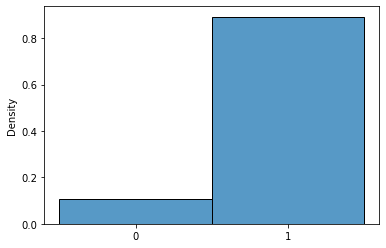

In [20]:
# Test Code
class DummyModule(nn.Module):
    def forward(self, state):
        return torch.FloatTensor([1,2]) # Constant output

# Sample 1000 actions
_actions = [epsilon_greedy(np.array([1,2,3,4]), DummyModule(), epsilon=0.2) for _ in range(1000)]

sns.histplot(_actions, discrete=True, stat="density")
plt.xticks([0,1])
plt.show()

_zeros = 1000 - sum(_actions)
# Note: This is a stochastic test. It produces a false error in 1% of the cases
assert 75 < _zeros < 125, f"Frequency of action 0 ({_zeros}) is outside the 99% confidence interval [76, 124]"

### c) Loss Function

In [21]:
mse = nn.MSELoss()

def compute_loss(q_network, target_network, states, actions, rewards, next_states, is_terminal, gamma = 0.99):
    # TODO Implement loss function
    # qvals = ...
    qvals = torch.gather(q_network.forward(states), 1, actions)
    next_actions = torch.argmax(q_network.forward(next_states), dim=1, keepdim=True)
    qvals_next = torch.gather(target_network.forward(next_states), 1, next_actions).detach()
    qvals_next[is_terminal] = 0
    
    # expected_qvals = ...
    expected_qvals = gamma * qvals_next + rewards

    loss = mse(qvals, expected_qvals)
    return loss